Base shape: (1000000, 960)
Learn shape: (500000, 960)
Query shape: (1000, 960)
Groundtruth shape: (1000, 100)
인덱스 생성 완료


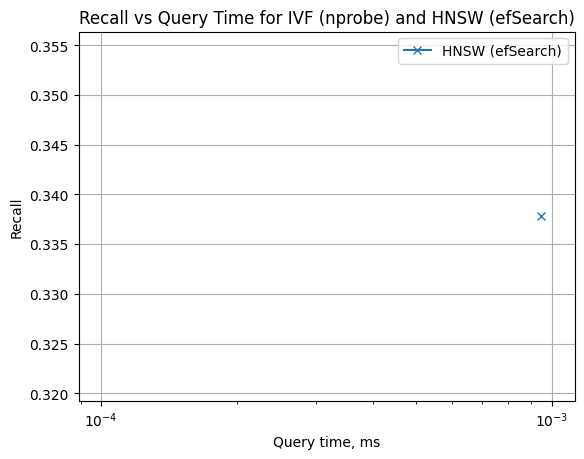

In [3]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

def read_fvecs(filename):
    with open(filename, 'rb') as f:
        # 읽기
        data = np.fromfile(f, dtype='int32')
        # 첫 번째 값을 차원으로 사용
        dim = data[0]
        # 데이터 변환 및 리턴
        return data.reshape(-1, dim + 1)[:, 1:].astype('float32')

def read_ivecs(filename):
    with open(filename, 'rb') as f:
        # 읽기
        data = np.fromfile(f, dtype='int32')
        # 첫 번째 값을 차원으로 사용
        dim = data[0]
        # 데이터 변환 및 리턴
        return data.reshape(-1, dim + 1)[:, 1:]

# 파일 경로 설정
base_path = '/data/matmang/gist/gist_base.fvecs'
learn_path = '/data/matmang/gist/gist_learn.fvecs'
query_path = '/data/matmang/gist/gist_query.fvecs'
groundtruth_path = '/data/matmang/gist/gist_groundtruth.ivecs'

# 파일 읽기
gist_base = read_fvecs(base_path)
gist_learn = read_fvecs(learn_path)
gist_query = read_fvecs(query_path)
gist_groundtruth = read_ivecs(groundtruth_path)

print(f'Base shape: {gist_base.shape}')
print(f'Learn shape: {gist_learn.shape}')
print(f'Query shape: {gist_query.shape}')
print(f'Groundtruth shape: {gist_groundtruth.shape}')

# 차원 수
dim = gist_base.shape[1]

# HNSW 인덱스 생성 및 학습
index_hnsw = faiss.IndexHNSWFlat(dim, 32)
index_hnsw.add(gist_base)

print("인덱스 생성 완료")

def search_and_measure(index, queries, groundtruth, k=5):
    start_time = time.time()
    distances, indices = index.search(queries, k)
    query_time = time.time() - start_time
    
    recall = []
    for i, neighbors in enumerate(indices):
        gt = set(groundtruth[i][:k])
        retrieved = set(neighbors)
        correct = len(gt & retrieved)
        recall.append(correct / k)
    
    avg_recall = np.mean(recall)
    avg_query_time = query_time / len(queries)
    
    return avg_recall, avg_query_time

efSearch_values = [100]
hnsw_results = []

for efSearch in efSearch_values:
    index_hnsw.hnsw.efSearch = efSearch
    recall, query_time = search_and_measure(index_hnsw, gist_query, gist_groundtruth, k=100)
    hnsw_results.append((recall, query_time))

hnsw_recall_values = [result[0] for result in hnsw_results]
hnsw_query_time_values = [result[1] for result in hnsw_results]
plt.plot(hnsw_query_time_values, hnsw_recall_values, label='HNSW (efSearch)', marker='x')

plt.xscale('log')
plt.xlabel('Query time, ms')
plt.ylabel('Recall')
plt.title('Recall vs Query Time for IVF (nprobe) and HNSW (efSearch)')
plt.legend()
plt.grid(True)
plt.show()